In [1]:
import os
import random
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D


In [2]:
path = "datatraffic"  # folder with all the class folders
labelFile = "labels.csv"  # file with all names of classes
steps_per_epoch_val = 502
batch_size_val = 50  # how many to process together
epochs_val = 10
imageDimesions = (32, 32, 3)
testRatio = 0.1  # if 1000 images split will 100 for testing
validationRatio = 0.2  # if 1000 images 20% of remaining 800 will be 160 for validation
# Resizing the images to 30x30x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

In [3]:
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        image_fromarray = Image.fromarray(curImg, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        images.append(resize_image)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [4]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio) 
#X train = ARRAY OF IMAGES TO TRAIN 
# #y_train = CORRESPONDING CLASS ID

In [5]:
print("Data Shapes")
print("Train", end = ""); print(X_train. shape,y_train.shape)
print("Validation", end = ""); print (X_validation.shape,y_validation. shape)
print("Test", end = ""); print(X_test.shape,y_test.shape)
assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:]==(imageDimesions))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:]==(imageDimesions))," The dimesionas of the Validation images are wrong "
assert(X_test.shape[1:]==(imageDimesions))," The dimesionas of the Test images are wrong"

Data Shapes
Train(34396, 32, 32, 3) (34396,)
Validation(8599, 32, 32, 3) (8599,)
Test(4778, 32, 32, 3) (4778,)


In [6]:
data=pd.read_csv(labelFile)
print("data shape ",data.shape, type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


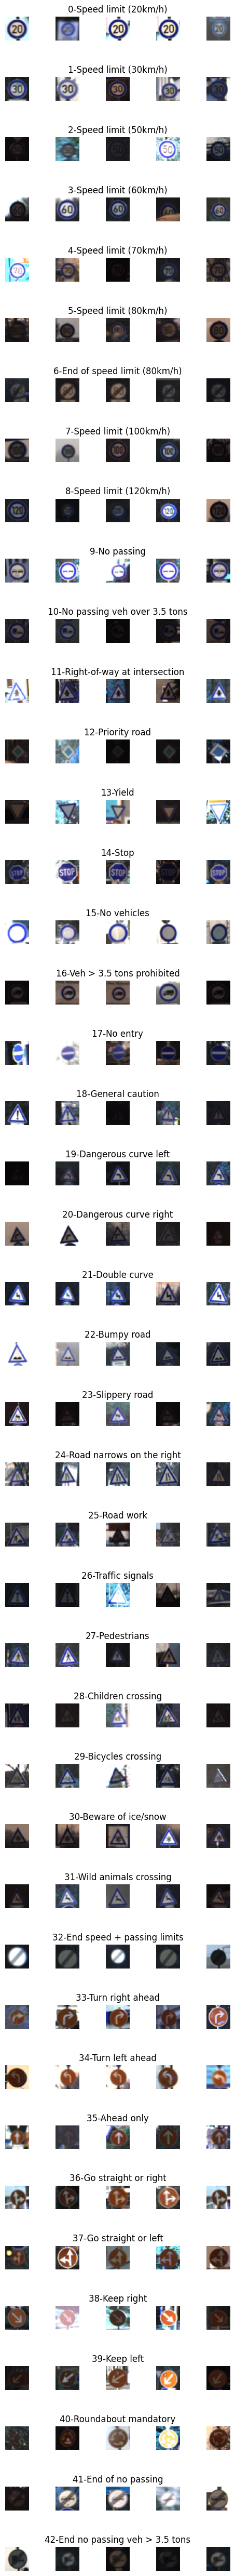

In [7]:
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs= plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected [random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+"-"+row["Name"])
            num_of_samples.append(len(x_selected))

[186, 1929, 1929, 1254, 1719, 1588, 374, 1247, 1214, 1298, 1752, 1145, 1915, 1880, 703, 583, 339, 976, 1028, 182, 319, 279, 352, 462, 226, 1308, 545, 195, 504, 232, 403, 682, 224, 640, 373, 1042, 351, 203, 1812, 270, 304, 213, 216]


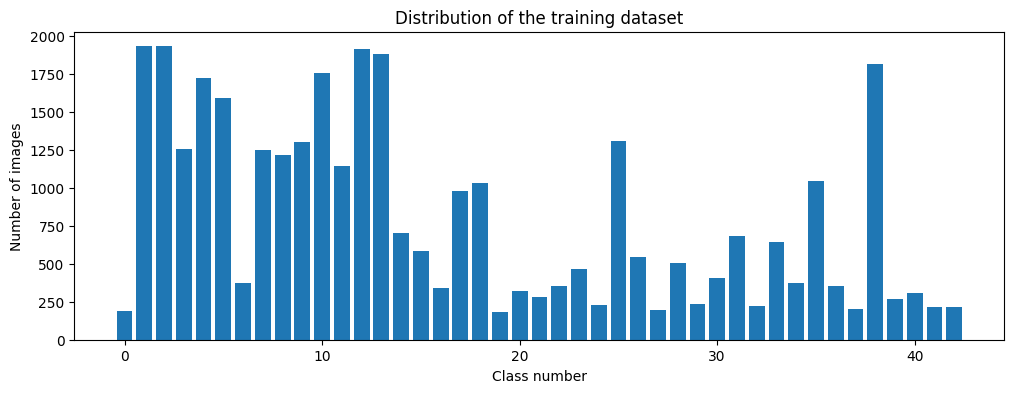

In [8]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [9]:

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)  # CONVERT TO GRAYSCALE
    img = equalize(img)    # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img/255           # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img

X_train = np.array(list(map(preprocessing, X_train)))  # TO ITERATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

In [10]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

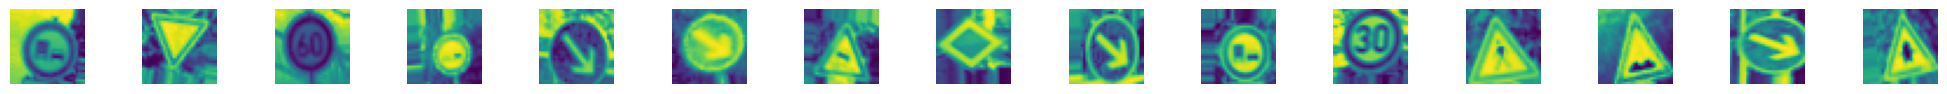

In [11]:
dataGen = ImageDataGenerator(
    width_shift_range=0.1,  # 0.1 = 10%
    height_shift_range=0.1,
    zoom_range=0.2,  # 8.2 MEANS CAN GO FROM 8.8 TO 1.2
    rotation_range=10  # DEGREES
)
shear_range = 0.1  # MAGNITUDE OF SHEAR ANGLE
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train, batch_size=20)  # REQUESTING DATA GENERATOR TO GENERATE IMAGES BATCH SIZE = NUMBER OF IMAGES
X_batch, y_batch = next(batches)

# TO SHOW AUGMENTED IMAGE SAMPLES
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0], imageDimesions[1]))
    axs[i].axis('off')
plt.show()

y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [16]:
def myModel():
    no_Of_Filters = 60
    size_of_Filter = (5, 5)  # THIS IS THE KERNEL THAT MOVES AROUND THE IMAGE TO GET THE FEATURES.
    # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32x32 IMAGE
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)  # SCALE DOWN ALL FEATURE MAPS TO GENERALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500  # NO. OF NODES IN HIDDEN LAYERS

    model = Sequential()
    model.add(Conv2D(no_Of_Filters, size_of_Filter, input_shape=(imageDimesions[0], imageDimesions[1], 1), activation='relu'))
    model.add(Conv2D(no_Of_Filters, size_of_Filter, activation='relu'))
    model.add(MaxPooling2D(pool_size=size_of_pool))  # DOES NOT AFFECT THE DEPTH/NO OF FILTERS
    
    model.add(Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu'))
    model.add(Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu'))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation='relu'))
    model.add(Dropout(0.5))  # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 8 NONE
    model.add(Dense(noOfClasses, activation='softmax'))  # OUTPUT LAYER

    # COMPILE MODEL
    model.compile(Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
    
    return model

In [17]:
model = myModel()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 60)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 4, 30)          0         
 g2D)                                                 

In [18]:
history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size_val),
                    steps_per_epoch=steps_per_epoch_val,
                    epochs=epochs_val,
                    # If you have a validation dataset
                    validation_data=(X_validation, y_validation))

Epoch 1/10
502/502 [==============================] - 91s 179ms/step - loss: 2.4712 - accuracy: 0.3069 - val_loss: 0.7654 - val_accuracy: 0.7771
Epoch 2/10
502/502 [==============================] - 89s 177ms/step - loss: 1.1402 - accuracy: 0.6483 - val_loss: 0.3526 - val_accuracy: 0.8938
Epoch 3/10
502/502 [==============================] - 89s 178ms/step - loss: 0.8047 - accuracy: 0.7515 - val_loss: 0.2020 - val_accuracy: 0.9441
Epoch 4/10
502/502 [==============================] - 89s 178ms/step - loss: 0.6159 - accuracy: 0.8078 - val_loss: 0.1627 - val_accuracy: 0.9489
Epoch 5/10
502/502 [==============================] - 89s 178ms/step - loss: 0.5204 - accuracy: 0.8388 - val_loss: 0.1097 - val_accuracy: 0.9683
Epoch 6/10
502/502 [==============================] - 88s 176ms/step - loss: 0.4522 - accuracy: 0.8551 - val_loss: 0.1137 - val_accuracy: 0.9687
Epoch 7/10
502/502 [==============================] - 89s 178ms/step - loss: 0.3946 - accuracy: 0.8764 - val_loss: 0.0858 - val_ac

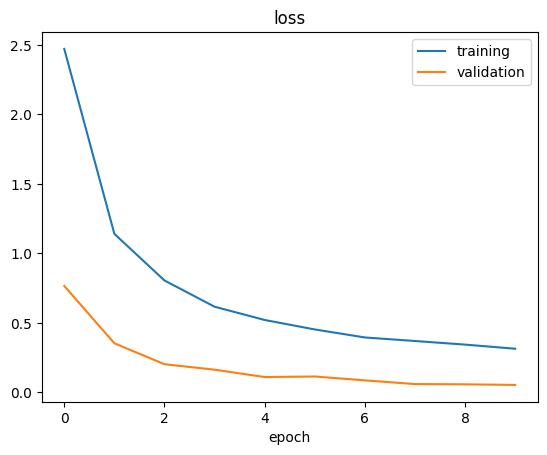

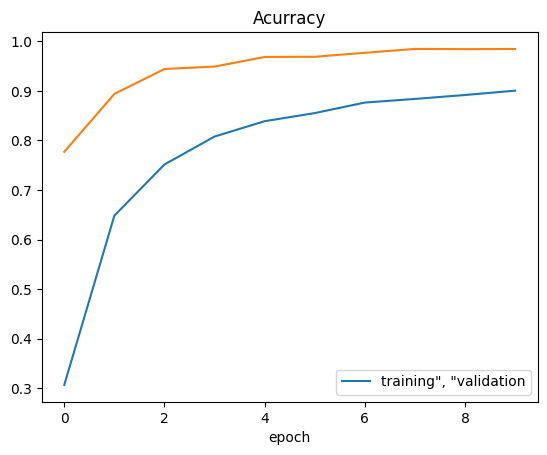

Test Score:  0.04961424320936203
Test Accuracy: 0.9853495359420776


In [20]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend (['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training", "validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test,y_test,verbose=0)
print('Test Score: ', score[0])
print('Test Accuracy:', score[1])

In [21]:
model.save("my_model")
model.save_weights("weights.h5")

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets
